In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import env
import dataprep

from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression 
from math import sqrt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import math

from sklearn.model_selection import train_test_split
import sklearn.linear_model
import sklearn.feature_selection
import sklearn.preprocessing
from scipy import stats
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector

# Predicting Home Values
Ella Xu
Junior Data Scientist | Zillow Data Science Team

# Goals
Zillow has a model that is designed to predict the property tax assessed values ('taxvaluedollarcnt') of Single Family Properties that had a transaction during 2017. The goal of this project is to look for insights that can help possibly improve this model, and make recommendations on how to improve it.

# Planning
* Setup my repository environment (.gitignore, README.md)
* Import and test my wrangle functions
* Define an test at least two hypothesis’s
* Train and Evalutate three different classification models.
* Create a csv file with predictions, from the model that perfoms the best
* Report my conclusions and next steps in a presentation.


# Executive Summary
* My polynomial Model had a Root Mean Squared Error (RMSE) of $184353. Beating my Baseline RMSE of $ 22896¶. The data suggest Bathrooms, Bedrooms, and Squarefeet to be the most valued features. I recommend removing outliers from these columns to improve future modeling.

# Acquiring the Data
To acquire the Zillow data, I used the zillow database in the Codeup SQL server, and selected the requested columns. I then selected only Single Family Residential and Inferred Single Family Residential from the 2017 properties using propertylandusetypeid.

In [2]:
zillow = dataprep.get_zillow_data()
zillow.head()
#Chose bedrooms, bathrooms, area, year_built because these features are important when evaluate home value 
#Didn't include rest of the columns because I spent too long to clean the data
#Too much nulls and outliers. 

Using cached csv


,bedrooms,bathrooms,area,tax_value,year_built,fips
0,0.0,0.0,NaN,27516.0,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6037.0


# Cleaning the Data

* Rename the columns to make it easy to read. 

                               'bedroomcnt':'bedrooms', 
                              'bathroomcnt':'bathrooms', 
                              'calculatedfinishedsquarefeet':'area',
                              'taxvaluedollarcnt':'tax_value', 
                              'yearbuilt':'year_built'.

* Remove outliers from 'bedrooms', 'bathrooms', 'squarefeet', and 'tax_value'.
There were some extremely large houses with 25 bathrooms that I believed would not represent the average Single Family Residential. So I removed these with statistics upper and lower bounds.

*  Use fips number to find the county names. Rename the fips number with the correct county name, LA_county, orange_county, and ventura_county. Replace the null value with median value in year_built columns. Also,I replace 1.75 bathrooms with 2.0 bathrooms count. 


* Convert column datatypes, year_built and fips to object datatype. Make sure all datatypes are correct and ready to use. 

* To make it easier to see how old a house was in 2017, feature engineering by add a column named home_age, home's years old.

* Split the data 80/20 train test split. 70/30 train validate split

In [3]:
# Import the train, validate and test data from the function we made in dataprep.py
train, validate, test = dataprep.prepare_zillow(dataprep.get_zillow_data())

Using cached csv


In [4]:
print(train.shape)
print(validate.shape)
print(test.shape)
#print out the shape of the train, validate and test to double check. 

(1055543, 10)
(452376, 10)
(376980, 10)


In [6]:
train.head(2)

,bedrooms,bathrooms,area,tax_value,year_built,home_age,county,county_LA_county,county_orange_county,county_ventura_county
878659,2.0,1.0,762.0,312730.0,1950.0,67.0,LA_county,1,0,0
413927,2.0,1.0,828.0,119114.0,1952.0,65.0,LA_county,1,0,0


In [6]:
train.info()
# Double check the datatype of each columns. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1055543 entries, 878659 to 1525367
Data columns (total 10 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   bedrooms               1055543 non-null  float64
 1   bathrooms              1055543 non-null  float64
 2   area                   1055543 non-null  float64
 3   tax_value              1055543 non-null  float64
 4   year_built             1055543 non-null  object 
 5   home_age               1055543 non-null  float64
 6   county                 1055543 non-null  object 
 7   county_LA_county       1055543 non-null  uint8  
 8   county_orange_county   1055543 non-null  uint8  
 9   county_ventura_county  1055543 non-null  uint8  
dtypes: float64(5), object(2), uint8(3)
memory usage: 67.4+ MB


In [7]:
train.describe()

,bedrooms,bathrooms,area,tax_value,home_age,county_LA_county,county_orange_county,county_ventura_county
count,1.055543e+06,1.055543e+06,1.055543e+06,1.055543e+06,1.055543e+06,1.055543e+06,1.055543e+06,1.055543e+06
mean,3.219526e+00,2.062676e+00,1.663781e+03,3.348739e+05,5.740161e+01,6.698600e-01,2.523791e-01,7.776092e-02
std,7.834944e-01,7.127042e-01,5.714532e+02,2.070981e+05,2.075536e+01,4.702635e-01,4.343778e-01,2.677951e-01
min,2.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,2.000000e+00,1.234000e+03,1.752610e+05,4.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.000000e+00,2.000000e+00,1.555000e+03,2.999190e+05,6.000000e+01,1.000000e+00,0.000000e+00,0.000000e+00
75%,4.000000e+00,2.500000e+00,2.004000e+03,4.600000e+05,6.800000e+01,1.000000e+00,1.000000e+00,0.000000e+00
max,5.000000e+00,4.000000e+00,3.410000e+03,9.509640e+05,2.050000e+02,1.000000e+00,1.000000e+00,1.000000e+00


# Explore the Train dataset

Initial Questions: 
    
    * What's the distribution of the home values?
    
    * What's the distribution of the building years?
    
    * Are homes in certain areas worth more than one other?
    
    * Are homes with more bedrooms and bathrooms worth more?
    
    * What are two features have strongest relationship with tax_value?
    
    

## Dataset Overview Questions: 

###  What's the distribution of the home values? 

<AxesSubplot:xlabel='tax_value'>

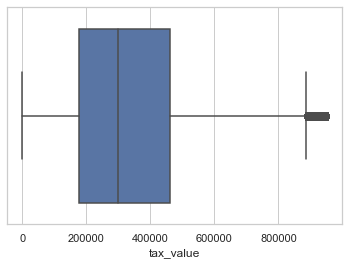

In [8]:
sns.set_theme(style="whitegrid")
sns.boxplot(data=train, x="tax_value")

In [9]:
train.tax_value.describe()

count    1.055543e+06
mean     3.348739e+05
std      2.070981e+05
min      1.000000e+00
25%      1.752610e+05
50%      2.999190e+05
75%      4.600000e+05
max      9.509640e+05
Name: tax_value, dtype: float64

In [10]:
print("The mean of the home values are", round(train.tax_value.mean(),2))
print("The min of the home values are", train.tax_value.min())
print("The max of the home values are",  train.tax_value.max())
# There are couple of lower bound outliers which are less than 175k.
# There are a couple outliers which are greater than 900k.

The mean of the home values are 334873.88
The min of the home values are 1.0
The max of the home values are 950964.0


### What's the distribution of the building years? 

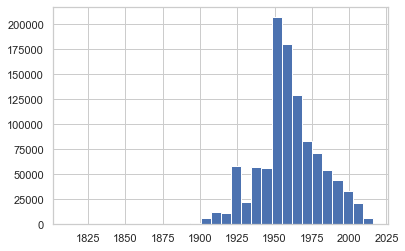

In [11]:
plt.hist(train[['year_built']], bins=30)
plt.show()

I created 30 bins to fit the distribution. The building years histgram shows a normal distribution. More than half of homes are built between 1960-1975.

### Are homes with more bedrooms and bathrooms worth more? How about square foot, area size? 


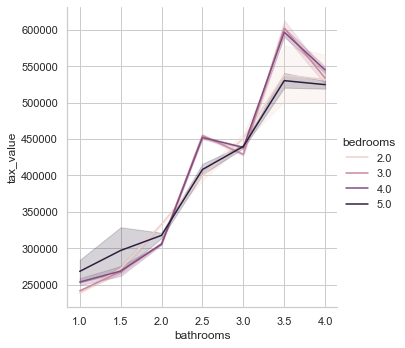

In [15]:
sns.relplot(
    data=train, x="bathrooms", y="tax_value",
    hue="bedrooms", kind="line",
)

Yes, homes with more bedrooms and bathrooms worth more. More often than not, adding a bedroom / bathrooms increases the value of a home. 

In [47]:
subset = train
subset['home_size'] = ""
subset.loc[subset.area <= 1600, 'home_size'] = "small"

subset.loc[(subset.area >1600) &(subset.area <= 2300), 'home_size'] = "medium"

subset.loc[(subset.area >2300) &(subset.area <= 3500), 'home_size'] = "large"


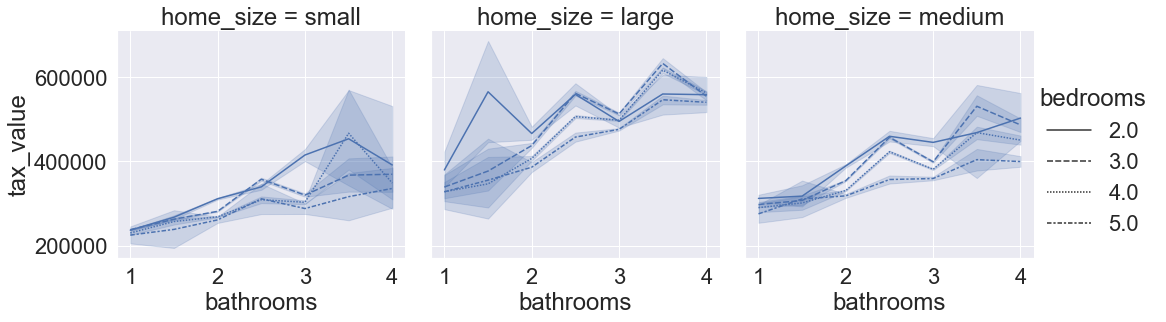

In [57]:
sns.relplot(
    data=subset, x="bathrooms", y="tax_value",col = "home_size", style = 'bedrooms',
    kind="line")



With the same count of bathrooms and bedrooms, homes with bigger size values more. More land and a bigger house will usually equate to more taxes that you will be paying.

### Are homes in certain areas worth more than one other? 

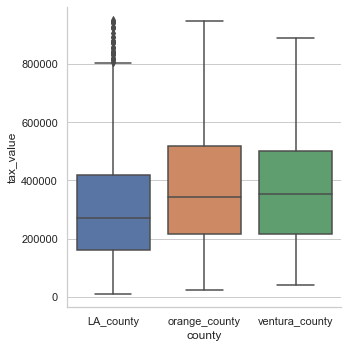

In [18]:
sns.catplot(x="county", y="tax_value",kind="box", data=train.sample(2000))

LA_county's homes overall have a lower average home values. The avg home value between organge county and ventura country are about the same. However, LA_county also have some very high price homes. 

### What are two features have strongest relationship with tax_value? 

In [7]:
## Scale our data. Columns that are suitble for scalling are, bedrooms, bathrooms, area, and home_age. 
def scale_data(train, validate, test, return_scaler=False):
    '''
    Scales the 3 data splits.
    
    takes in the train, validate, and test data splits and returns their scaled counterparts.
    
    If return_scaler is true, the scaler object will be returned as well.
    '''
    columns_to_scale = ['bedrooms', 'bathrooms', 'area','home_age']
    
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()# create copy to avoid overwrite. 
    
    scaler = sklearn.preprocessing.MinMaxScaler() # import the min max scaler method. 
    scaler.fit(train[columns_to_scale])
    
    train_scaled[columns_to_scale] = scaler.transform(train[columns_to_scale]) #transform our data
    validate_scaled[columns_to_scale] = scaler.transform(validate[columns_to_scale])
    test_scaled[columns_to_scale] = scaler.transform(test[columns_to_scale])
    
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, validate_scaled, test_scaled

In [8]:
train_scaled, validate_scaled, test_scaled = scale_data(train, validate, test)
#let's input our train validate and test data, and transform them all to scaled data.

In [9]:
#once we have scaled our data, then we will split out scaled data and ready for our model. 
X_train_scaled = train_scaled.drop(columns=['tax_value','county','county_LA_county','year_built'])
#Drop the tax_value because tax_value is our target variable. 
#Drop the county because I already hot encoded them. 
#Drop county_LA_county because, I encoded all county, even drop one columns make no difference. 
#Drop year_built because I created home age, and I can scale the home easier. 
X_validate_scaled = validate_scaled.drop(columns=['tax_value','county','county_LA_county','year_built'])

X_test_scaled = test_scaled.drop(columns=['tax_value','county','county_LA_county','year_built'])

y_train = train[['tax_value']]

y_validate = validate[['tax_value']]

y_test = test[['tax_value']]

***Select K Best***


Looks at each feature in isolation against the target based on correlation
fastest of all approaches covered in this lesson
doesn't consider feature interactions

In [10]:
kbest = SelectKBest(f_regression, k=3)
kbest.fit(X_train_scaled, y_train)

SelectKBest(k=3, score_func=<function f_regression at 0x7f9ae59ccf70>)

In [11]:
X_train_scaled.columns[kbest.get_support()]

Index(['bathrooms', 'area', 'home_age'], dtype='object')

The select k best get us the best three features are bathrooms, area, home age. 

***RFE Recursive Feature Elimination***

Progressively eliminate features based on importance to the model
Requires a model with either a .coef_ or .feature_importances_ property

In [12]:
model = LinearRegression() #first, we will create the model. 
rfe = RFE(model, n_features_to_select=3)
rfe.fit(X_train_scaled, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=3)

In [13]:
X_train_scaled.columns[rfe.get_support()]# Get list of top K features. 

Index(['bedrooms', 'area', 'home_age'], dtype='object')

Recursive Feature Elimination Top Three Features are bedrooms area and home_age. 


# Statistical Test Questions: 

### 1. Are homes with more bedrooms worth more?

### 2. Do younger homes worth more? 

In [28]:
alpha = 0.05 #let's assume alpha is 0.05

### 1. Are homes with more bedrooms worth more?
H0: There is no difference in tax_value between homes with 2 or 3 bedrooms vs homes with 4 or 5 bedrooms.

Ha: There is a difference in tax_value between homes with 2 or 3 bedrooms vs homes with 4 or 5 bedrooms.


<AxesSubplot:xlabel='bedrooms', ylabel='tax_value'>

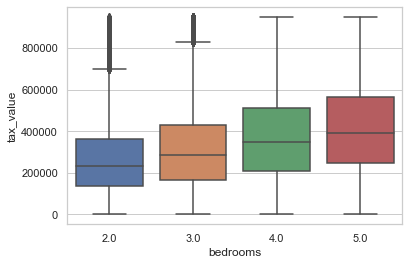

In [24]:
sns.boxplot(x="bedrooms", y="tax_value", data=train)

In [26]:
# I'm going to create some array's for this question
tax_value_1_2Bd = train[(train.bedrooms == 2) | (train.bedrooms == 3)].tax_value
tax_value_4_5Bd = train[(train.bedrooms == 4) | (train.bedrooms == 5)].tax_value

In [29]:
# Perform a t test becuase we are comparsing two means,
# This is a two-sampled, two-tailed test. 
t, p = stats.ttest_ind(tax_value_1_2Bd,tax_value_4_5Bd, equal_var=False )
t, p

if p < alpha:
    print("We reject the null hypothesis")

else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis


Conclusion: There is a difference in tax_value between homes with 2 or 3 bedrooms vs homes with 4 or 5 bedrooms.

Takeaway: The data shows that increased bedroom count correlates with increased tax_value.

### 2. Are younger homes higher in tax_value than old homes?
H0: Home ages have no relationship with tax values 

Ha: Home ages have relationship with tax values 

(0.0, 2000000.0)

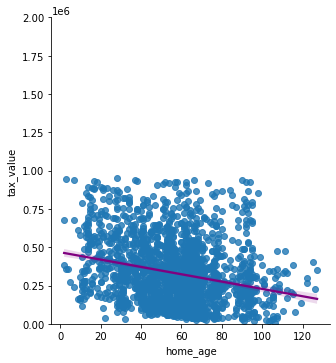

In [76]:
sns.lmplot(data = train.sample(2000), x = 'home_age', y = 'tax_value',line_kws={'color': 'purple'})
plt.ylim(0,2000000)

In [30]:
corr, p = stats.pearsonr(train.home_age, train.tax_value)


corr, p


if p < alpha:
    print("We reject the null hypothesis")

else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis


Conclusion: Homes older than the average cost less than homes younger than the average.

Takeaway: home_age was number 3 in most valued features, so this makes sense. Younger homes have higher tax value than older homes.

## Key Takeaways From Exploration 

* These single families were built in 1900-2016.

* The more rooms, the higher the value of the home

* More land and a bigger house will usually equate to more taxes that you will be paying.

* The data shows that increased bedroom count correlates with increased tax_value.

* Younger homes have higher tax value.

* RFE top three features are bedrooms, area and home_age. 

* K Best top three features are bathrooms, area and home ago.

# Modeling 

## Baseline Model

In [14]:
# Need to create y_train, y_validate, y_test to evaluate the baseline model. 
y_train = train[['tax_value']]

y_validate = validate[['tax_value']]

y_test = test[['tax_value']]

In [15]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# The Project specs told us to use mean for our baseline
# 1. Predict tax_value_pred_mean
tax_value_pred_mean = y_train.tax_value.mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

# 2. RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean) ** (0.5)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean) ** (0.5)

metric_df = pd.DataFrame(data=[
            {
                'model': 'Baseline', 
                'RMSE_train': rmse_train,
                'RMSE_validate': rmse_validate
                }
            ])
metric_df

,model,RMSE_train,RMSE_validate
0,Baseline,207098.033058,207249.76852


## Three Models

### Multiple Regression + RFE

In [16]:
#I decided to use REF top features to run model 1. 
lm0 = sklearn.linear_model.LinearRegression()
lm0.fit(X_train_scaled, y_train.tax_value)
rfe = sklearn.feature_selection.RFE(lm0, n_features_to_select=3)

    # Fit the thing
rfe.fit(X_train_scaled, y_train.tax_value)

# use the thing!
y_train['RFE'] = rfe.predict(X_train_scaled)
# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.RFE) ** (1/2)

# predict validate
y_validate['RFE'] = lm0.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.RFE) ** (1/2)

print("RMSE for Multiple Regression + RFE using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Multiple Regression + RFE using LinearRegression
Training/In-Sample:  185278.53491505553 
Validation/Out-of-Sample:  184117.51786929302


In [17]:
metric_df = metric_df.append({
    'model': 'Multiple Regression + RFE', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)
metric_df

,model,RMSE_train,RMSE_validate
0,Baseline,207098.033058,207249.768520
1,Multiple Regression + RFE,185278.534915,184117.517869


### LinearRegression (OLS)

In [18]:
# I decided to use all features in x_ train scaled to run model 2, 
# because all features are very important, and I want to see if this
# model can perfom better than RFE since there are more features. 
lm2 = LinearRegression()
lm2.fit(X_train_scaled, y_train.tax_value)
# predict train
# 
# use the thing!
# 
y_train['OLS'] = lm2.predict(X_train_scaled)
# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.OLS) ** (1/2)

# predict validate
y_validate['OLS'] = lm2.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.OLS) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  184217.69675431252 
Validation/Out-of-Sample:  184117.51786929302


In [19]:
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)
metric_df

,model,RMSE_train,RMSE_validate
0,Baseline,207098.033058,207249.768520
1,Multiple Regression + RFE,185278.534915,184117.517869
2,OLS Regressor,184217.696754,184117.517869


## Polynomial

In [20]:
# I decided to use polynomial for model 3. 
#Generate a new feature matrix consisting of all polynomial combinations 
#of the features with degree less than or equal to the specified degree.
# Polynomial provides the best approximation of the relationship between the dependent and independent variable. 
from sklearn.preprocessing import PolynomialFeatures

In [21]:
X_train_scaled.head()

,bedrooms,bathrooms,area,home_age,county_orange_county,county_ventura_county
878659,0.000000,0.000000,0.222777,0.323529,0,0
413927,0.000000,0.000000,0.242149,0.313725,0,0
316568,0.000000,0.000000,0.410625,0.313725,0,0
268737,1.000000,0.666667,0.828295,0.083333,1,0
846980,0.666667,0.333333,0.357206,0.303922,0,0


In [22]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree =2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['polynomial'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.polynomial)**(1/2)

# predict validate
y_validate['polynomial'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.polynomial)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Polynomial Model, degrees=2
Training/In-Sample:  181794.75473340097 
Validation/Out-of-Sample:  181743.20843957507


In [23]:
metric_df = metric_df.append({
    'model': 'polynomial', 
    'RMSE_train': rmse_train,
    'RMSE_validate': rmse_validate,
    }, ignore_index=True)
metric_df

,model,RMSE_train,RMSE_validate
0,Baseline,207098.033058,207249.768520
1,Multiple Regression + RFE,185278.534915,184117.517869
2,OLS Regressor,184217.696754,184117.517869
3,polynomial,181794.754733,181743.208440


### Evaluate on Test

The Polynomial Model had the best Root Mean Squared Error.
Validate Dataset had an RMSE of $181743.


I will use polynomial model for my Test Dataset!

In [127]:
# predict validate
y_test['polynomial'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_validate.tax_value, y_validate.polynomial)**(1/2)

rmse_test

180751.21847646107

## My polynomial Model had a Root Mean Squared Error (RMSE) of $180751. 

## Beating my Baseline RMSE of $26498

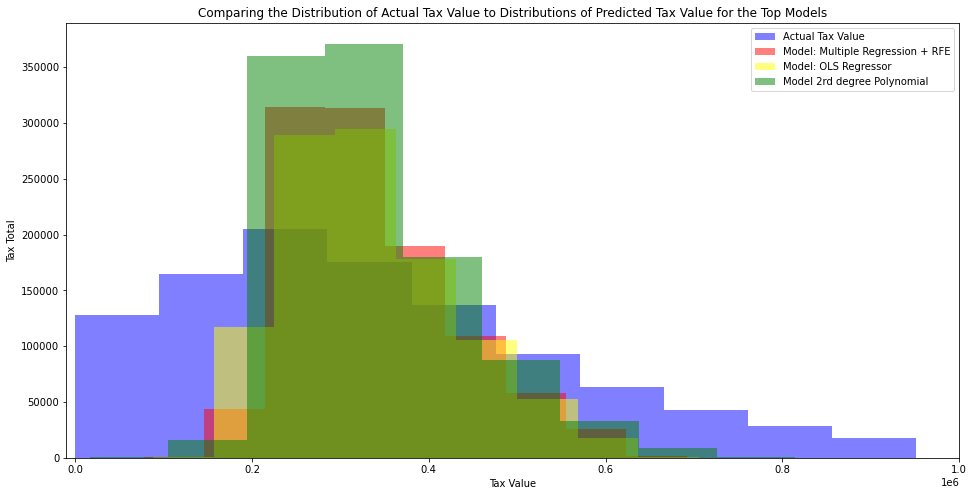

In [24]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_train.tax_value, color='blue', alpha=.5, label="Actual Tax Value")
plt.hist(y_train.RFE, color='red', alpha=.5, label="Model: Multiple Regression + RFE")
plt.hist(y_train.OLS, color='yellow', alpha=.5, label="Model: OLS Regressor")
plt.hist(y_train.polynomial, color='green', alpha=.5, label="Model 2rd degree Polynomial")
plt.xlabel("Tax Value")
plt.ylabel("Tax Total")
plt.title("Comparing the Distribution of Actual Tax Value to Distributions of Predicted Tax Value for the Top Models")
plt.legend()
plt.xlim(-10000,1000000)
plt.show()

By looking at the Distribution of Actual Tax Value to Distributions, we can tell the 2nd degree polynomial model capture and cover the most of our data (area in blue). 

# Conclusion 

The polynomial model perform with  a Root Mean Squared Error (RMSE) of $180751.
Beating my Baseline RMSE of $26498

# Key Findings 


There is somewhat of a relationship between bathrooms, square feet, and bedroom count in predicting the tax value dollar count of single family units. Bathrooms and bedrooms count were shown as the biggest driver.

Also, data shows homes that are newer appraise at a higher value. I think that critical parts of the house, like plumbing, electrical, the roof, and appliances are newer and therefore less likely to break down, can generate savings for a buyer

# Recomandations

The data suggest Bathrooms, Bedrooms, and Squarefeet to be the most valued features. I recommend removing outliers from these columns to improve future modeling.

# Next Steps

With more time I would work on improving the model adding more parameters
